<a href="https://www.kaggle.com/code/fbasampaio/eda-marketplace-brazil?scriptVersionId=220825593" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

 
# **Context**

The purpose of this analysis is to present an EDA (Exploratory Data Analysis) of Olist Store, a Brazilian marketplace. The dataset contains detailed information on orders placed between 2016 and 2018, covering various aspects such as order status, pricing, payment methods, shipping performance, and geolocation data, including latitude and longitude.

This is real business data provided by Olist, with some sensitive information anonymized. I hope this notebook serves as a useful resource, and I welcome any feedback or suggestions you may have.

 
 # **Introduction**
 
- **First step:** Data Import, Unification, Cleaning, and Organization:
The first step involves importing the dataset, unifying different tables, cleaning any inconsistencies, and organizing the data for further analysis.
- **Second step:** Distribution of Values and Orders:
In this step, we analyze the distribution of order values and the frequency of orders to gain insights into customer behavior and pricing trends.
- **Third step:** Verification of Deliveries and Products:
This stage focuses on examining the delivery performance and product details, including shipping times and product categories.
- **Fourth step:** Geolocation and Correlation Analysis:
Here, we analyze the geolocation data (latitude and longitude) to understand regional trends and perform correlation analysis between variables like shipping performance and distance.

**First Steps:**

- Import the necessary libraries (Completed)
- Load the datasets (Completed)
- Consolidate the datasets into a single main dataset (Completed)
- Adjust the order and delivery dates for the products (Completed)
- Generate a summary table detailing each feature, including size, name, type, null values, unique values, and entropy (Completed)

In [1]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
import requests
from collections import Counter
from PIL import Image
from matplotlib.ticker import FuncFormatter
#------------------------------------- 
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib
from scipy import stats 
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl

In [2]:
#Importing Datasets
df_item = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv")
df_reviews = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv")
df_orders = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv")
df_products = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv")
df_geolocation = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv")
df_sellers = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv")
df_order_pay = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv")
df_customers = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv")
df_category = pd.read_csv("/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv")

In [3]:
# Merging Datasets
df_train = df_orders.merge(df_item, on='order_id', how='left')
df_train = df_train.merge(df_order_pay, on='order_id', how='outer', validate='m:m')
df_train = df_train.merge(df_reviews, on='order_id', how='outer')
df_train = df_train.merge(df_products, on='product_id', how='outer')
df_train = df_train.merge(df_customers, on='customer_id', how='outer')
df_train = df_train.merge(df_sellers, on='seller_id', how='outer')

In [4]:
df_train['order_purchase_timestamp'] = pd.to_datetime(df_train['order_purchase_timestamp'])

# Transforming the columns (Order purchase)
df_train['day_of_week_name'] = df_train['order_purchase_timestamp'].dt.strftime('%A')
df_train['month_year'] = df_train['order_purchase_timestamp'].dt.strftime('%Y %m')
df_train['day_month_year'] = df_train['order_purchase_timestamp'].dt.strftime('%Y-%m-%d')
df_train['day_of_week_int'] = df_train['order_purchase_timestamp'].dt.weekday + 1
df_train['hour'] = df_train['order_purchase_timestamp'].dt.hour
df_train['month'] = df_train['order_purchase_timestamp'].dt.month
df_train['year'] = df_train['order_purchase_timestamp'].dt.year
df_train['order_purchase_timestamp'] = pd.to_datetime(df_train['order_purchase_timestamp'])
df_train['date'] = df_train['order_purchase_timestamp'].dt.to_period('M')
df_train['datetime'] = df_train['order_purchase_timestamp']

# Transforming the columns (Delivered customer)
df_train['order_delivered_customer_date'] = pd.to_datetime(df_train['order_delivered_customer_date'])
df_train['day_month_year_delivered'] = df_train['order_delivered_customer_date'].dt.strftime('%Y-%m-%d')
df_train['day_month_year_delivered'] = pd.to_datetime(df_train['day_month_year_delivered'])
df_train['day_month_year'] = pd.to_datetime(df_train['day_month_year'])
df_train['delivery_time'] = (df_train['order_delivered_customer_date'] - df_train['order_purchase_timestamp']).dt.days #average delivery days

In [5]:

def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

def cross_heatmap(df, cols, normalize=False, values=None, aggfunc=None):
    temp = cols
    cm = sns.light_palette("green", as_cmap=True)
    return pd.crosstab(df[temp[0]], df[temp[1]], 
                       normalize=normalize, values=values, aggfunc=aggfunc).style.background_gradient(cmap = cm)

In [6]:
resumetable(df_train)

Dataset Shape: (119143, 50)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,order_id,object,0,99441,d455a8cb295653b55abda06d434ab492,7f39ba4c9052be115350065d07583cac,9dc8d1a6f16f1b89874c29c9d8d30447,16.46
1,customer_id,object,0,99441,944b72539d7e1f7f7fc6e46639ef1fe3,d7fc82cbeafea77bd0a8fbbf6296e387,d9442164acf4b03109425633efaa0cfc,16.46
2,order_status,object,0,8,delivered,delivered,delivered,0.25
3,order_purchase_timestamp,datetime64[ns],0,98875,2017-09-26 22:17:05,2017-10-18 08:16:34,2017-10-12 13:33:22,16.44
4,order_approved_at,object,177,90733,2017-09-27 22:24:16,2017-10-18 23:56:20,2017-10-12 13:49:22,16.28
5,order_delivered_carrier_date,object,2086,81018,2017-09-29 15:53:03,2017-10-20 14:29:01,2017-10-17 15:42:42,16.03
6,order_delivered_customer_date,datetime64[ns],3421,95664,2017-10-07 16:12:47,2017-10-27 16:46:05,2017-10-24 20:17:44,16.40
7,order_estimated_delivery_date,object,0,459,2017-10-30 00:00:00,2017-11-09 00:00:00,2017-11-06 00:00:00,8.47
8,order_item_id,float64,833,21,1.0,1.0,1.0,0.72
9,product_id,object,833,32951,a2ff5a97bf95719e38ea2e3b4105bce8,a2ff5a97bf95719e38ea2e3b4105bce8,a2ff5a97bf95719e38ea2e3b4105bce8,13.63


# **Exploratory Data Analysis** 

**Second Step:**

- Analyze the distribution of orders by month and year (Completed)
- Evaluate purchase times and days of the week (Completed)
- Assess the scalability of order values between 2017 and 2018 (Completed)
Examine the price distribution, focusing on low and high values (Completed)

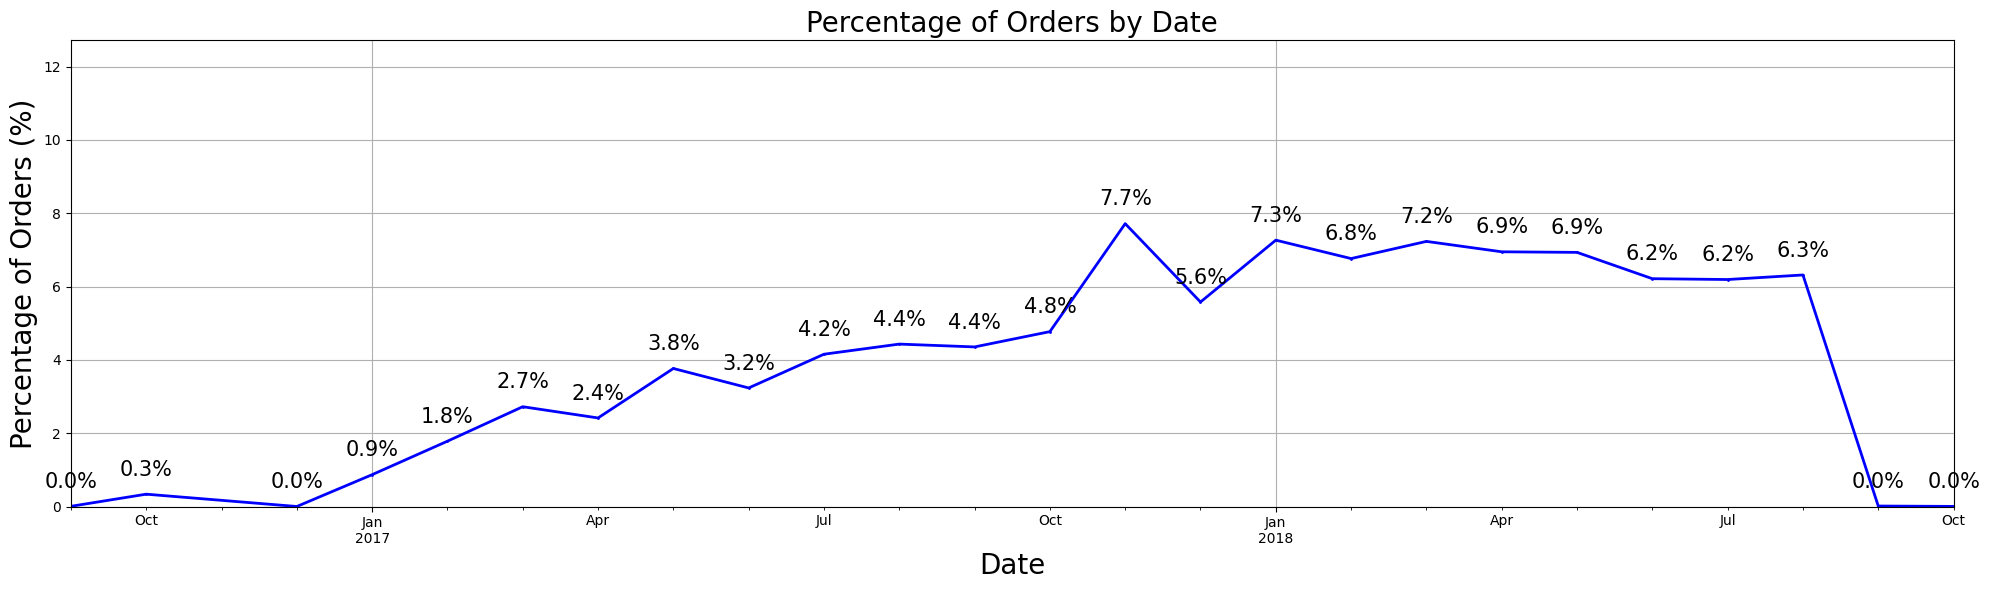

In [7]:
daily_counts = df_train.groupby('date')['order_id'].count()
percentage_counts = (daily_counts / daily_counts.sum()) * 100
plt.figure(figsize=(20, 6))

# Plot the daily counts of orders as percentages, showing the trend over time
line_plot = percentage_counts.plot(color='blue', marker='o', linestyle='-', linewidth=2, markersize=1)

# Set the title of the plot to describe what is being shown
plt.title('Percentage of Orders by Date', fontsize=20)

# Label the x-axis as 'Date' to indicate the time period represented
plt.xlabel('Date', fontsize=20)

# Label the y-axis as 'Percentage of Orders (%)' to indicate the quantity being measured
plt.ylabel('Percentage of Orders (%)', fontsize=20)

# Enable the grid to enhance readability and make it easier to interpret the data
plt.grid(True)

# Set the limits for the y-axis to provide a clearer view of the data range
plt.ylim(0, percentage_counts.max() + 5)

# Annotate each point on the line with its percentage value
for x, y in zip(percentage_counts.index, percentage_counts):
    plt.text(x, y + 0.5, f'{y:.1f}%', ha='center', fontsize=15, color='black')

# Display the plot to the user
plt.tight_layout()  
plt.show()

We observe a notable 7.7% spike in orders due to Black Friday, which occurred on November 24th, 2017.

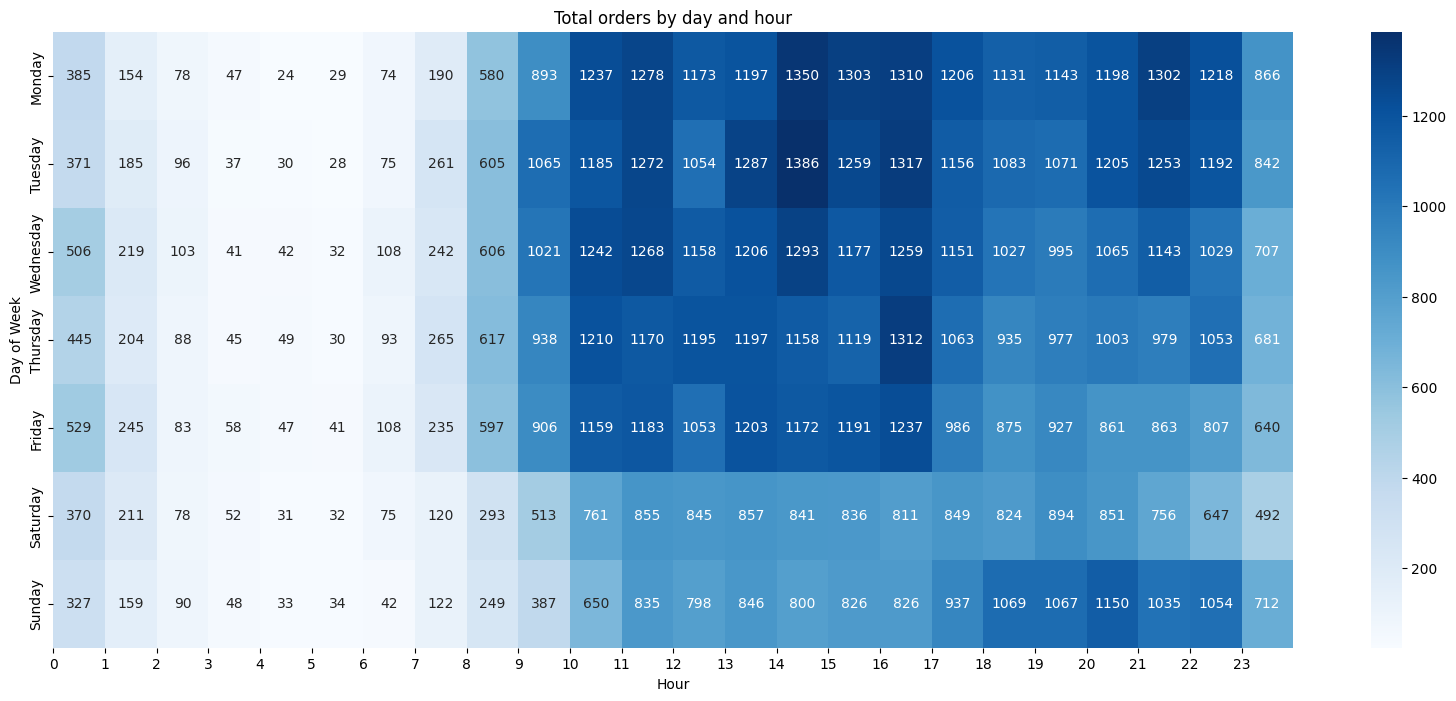

In [8]:
# Create a count table by grouping the data by day of the week and hour
g5 = df_train.groupby(['day_of_week_name', 'hour']).size().reset_index(name='count')

# Create a pivot table to reshape the data for heatmap visualization
tabela_pivot = g5.pivot(index='day_of_week_name', columns='hour', values='count')

# Define the order of the days of the week
g6 = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Reindex the pivot table to ensure the days are in the correct order
tabela_pivot = tabela_pivot.reindex(g6)

# Set up the figure size for the heatmap
plt.figure(figsize=(20, 8))
# Create the heatmap using Seaborn
ax = sns.heatmap(tabela_pivot, cmap="Blues", annot=True, fmt='d', cbar=True)

# Additional settings for the axes
ax.set_xlabel('Hour') 
ax.set_ylabel('Day of Week')
ax.set_title('Total orders by day and hour')  
# Set the x-ticks to show hour labels (0-23)
plt.xticks(ticks=range(24), labels=[str(i) for i in range(24)])

plt.show()


The peak shopping times are between Monday and Friday, from 9:00 AM to 6:00 PM, aligning with typical business hours and reflecting Brazilian consumer behavior.

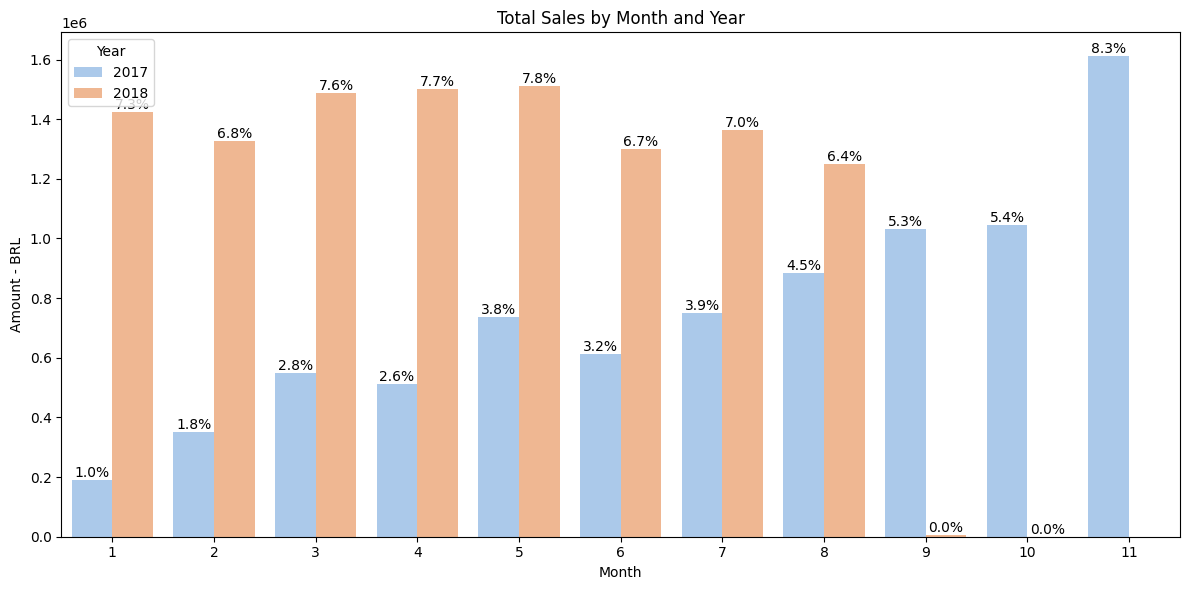

In [9]:

from tabulate import tabulate

df_train['order_purchase_year'] = df_train['order_purchase_timestamp'].apply(lambda x: x.year)
df_train['order_purchase_month'] = df_train['order_purchase_timestamp'].apply(lambda x: x.month)


df_orders_compare = df_train.query('order_purchase_year in (2017, 2018) & order_purchase_month <= 11')
year_orders = df_orders_compare['order_purchase_year'].value_counts()

sales_by_month = df_orders_compare.groupby(['year', 'month'])['payment_value'].sum().unstack()

sales_long = sales_by_month.reset_index().melt(id_vars='year', var_name='month', value_name='total_sales')

sales_table = sales_by_month.reset_index()
#print("\nSales by Month and Year:")
#print(tabulate(sales_table, headers='keys', tablefmt='pretty', showindex=False))

plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=sales_long, x='month', y='total_sales', hue='year', palette='pastel')

plt.title('Total Sales by Month and Year')
plt.xlabel('Month')
plt.ylabel('Amount - BRL')
plt.legend(title='Year')

for p in bar_plot.patches:
    height = p.get_height()
    total = sales_long['total_sales'].sum()
    percentage = (height / total) * 100
    bar_plot.annotate(f'{percentage:.1f}%', 
                      (p.get_x() + p.get_width() / 2., height), 
                      ha='center', va='bottom')

plt.tight_layout()
plt.show()


The total sales amount in **2017** was 9,334,920.90 BRL is approximately 1,717,479.55 USD(45%), while in **2018**, it reached 11,167,775.97 BRL is approximately 2,055,094.13 USD (54%). This represents a growth rate of 19.63% from one year to the next.

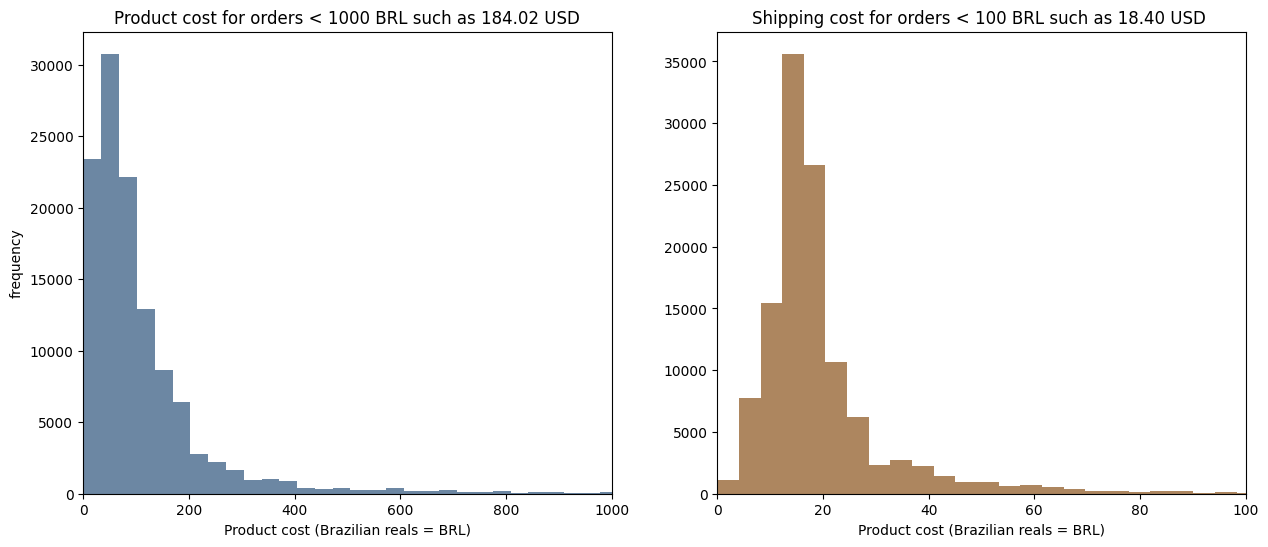

In [10]:
plt.figure(figsize=(15, 6))
# Histogram for total product cost
plt.subplot(1, 2, 1)
plt.hist(df_train['price'], bins=200, color='#6c87a3')
plt.title('Product cost for orders < 1000 BRL such as 184.02 USD')
plt.xlabel('Product cost (Brazilian reals = BRL)')
plt.ylabel('frequency')
plt.xlim([0, 1000])
# Histogram for total shipping cost
plt.subplot(1, 2, 2)
plt.hist(df_train['freight_value'], bins=100, color='#ad865f')
plt.title('Shipping cost for orders < 100 BRL such as 18.40 USD ')
plt.xlabel('Product cost (Brazilian reals = BRL)')
plt.xlim([0, 100])
plt.show()


Most sales are made for amounts less than 400 BRL, equivalent to approximately 125.07 USD.
Of these amounts, the highest purchase peak is for 10 BRL, equivalent to approximately 3.13 USD.
- Lowest price 0.85 BRL, equivalent to approximately 0.27 USD.
- Average price 120.65 BRL, equivalent to approximately 37.83 USD.
- Maximum price 67,350 BRL, equivalent to approximately 21,088.40 USD.



**Third Step:**

- Analyze product status (Completed)
- Determine the average product delivery date (Completed)
- Examine the distribution of review scores by product (Completed)
- Identify the top 5 products with the highest sales (Completed)


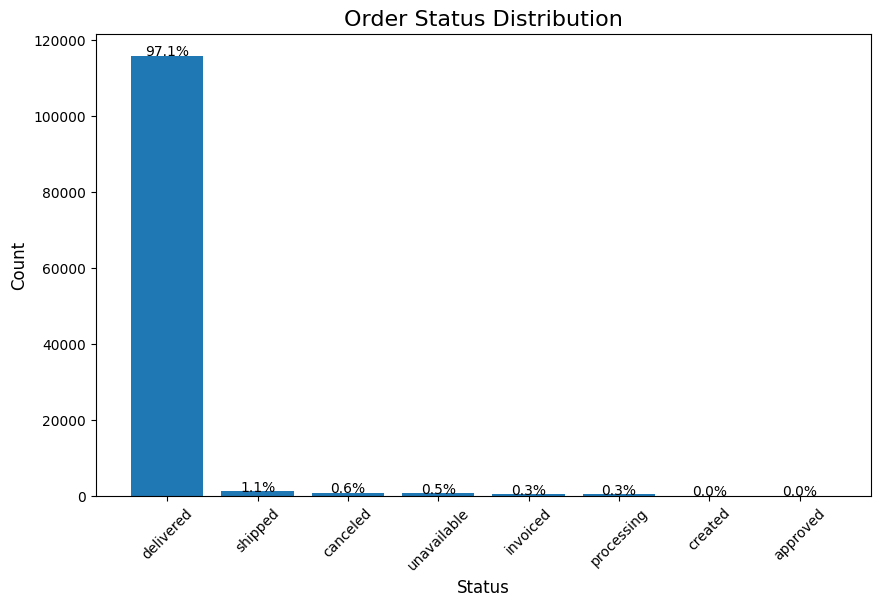

In [11]:
order_status_counts = df_train['order_status'].value_counts()

total = order_status_counts.sum()
percentages = (order_status_counts / total) * 100

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(order_status_counts.index, order_status_counts.values)

for i in range(len(order_status_counts)):
    ax.text(i, order_status_counts.iloc[i] + 0.5, f'{percentages.iloc[i]:.1f}%', ha='center', fontsize=10)

ax.set_title('Order Status Distribution', fontsize=16)
ax.set_xlabel('Status', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

plt.xticks(rotation=45)

plt.show()

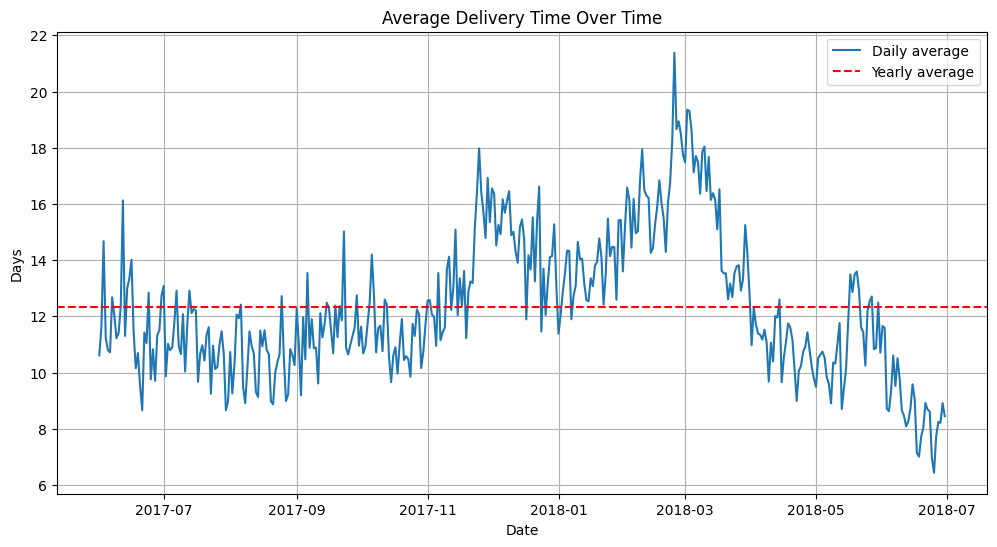

In [12]:
df_grouped = df_train.groupby('day_month_year').agg(
    total_orders=('order_id', 'count'),          
    avg_delivery_time=('delivery_time', 'mean') # average delivery days
    
).reset_index()

start_date = '2017-06-01'
end_date = '2018-06-30'
filtered_df = df_grouped[(df_grouped['day_month_year'] >= start_date) & (df_grouped['day_month_year'] <= end_date)]


plt.figure(figsize=(12, 6))
plt.plot(filtered_df['day_month_year'], filtered_df['avg_delivery_time'], label='Daily average')

yearly_avg = filtered_df['avg_delivery_time'].mean()
plt.axhline(y=yearly_avg, color='r', linestyle='--', label='Yearly average')

plt.xlabel('Date')
plt.ylabel('Days')
plt.title('Average Delivery Time Over Time')
plt.legend()
plt.grid(True)

plt.show()



97% of the products have been delivered, with an average delivery time of approximately 13 days. However, there was a peak delivery time of 20 days noted in March 2018. Despite this increase in delivery time, the number of products receiving a review score of 5 remained high. This can be attributed to the increase in sales during the same period, as indicated in the graphs above, which show a rise from 6.8% to 7.3% in sales.

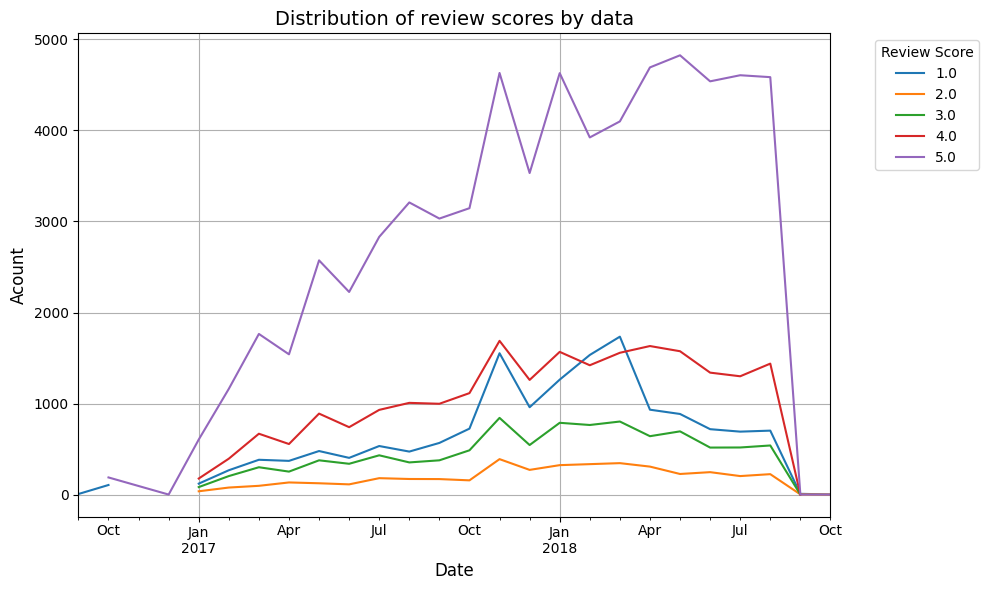

In [13]:
df_grouped = df_train.groupby(['date', 'review_score']).size().unstack()

df_grouped.plot(kind='line', figsize=(10, 6))

plt.title('Distribution of review scores by data', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Acount', fontsize=12)
plt.legend(title='Review Score', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

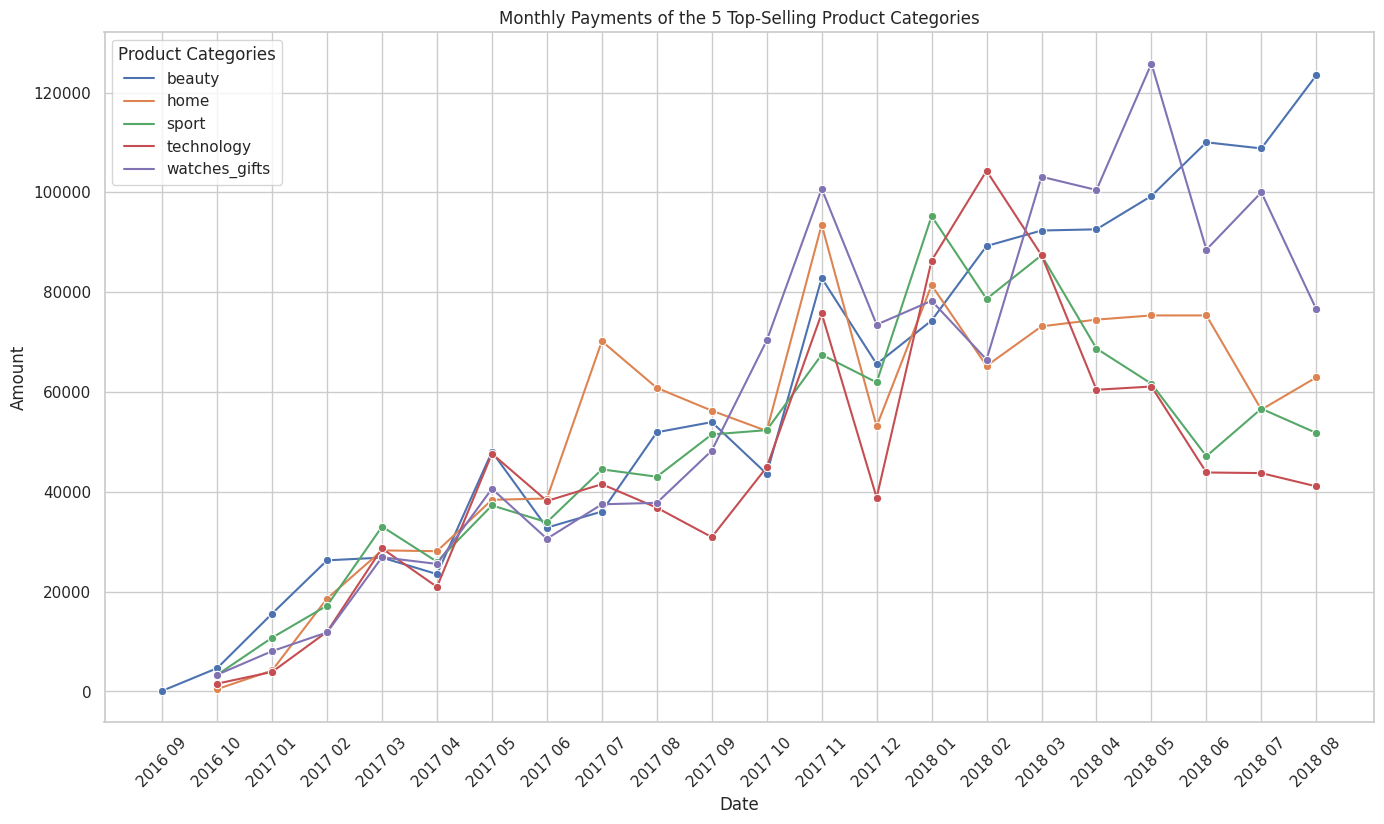

In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


category_translation = {
   'beleza_saude': 'beauty',
    'cama_mesa_banho': 'home',
   'esporte_lazer': 'sport',
   'informatica_acessorios': 'technology',
   'relogios_presentes': 'watches_gifts'

}

df_train['product_category_name'] = df_train['product_category_name'].replace(category_translation)

df_grouped = df_train.groupby(['month_year', 'product_category_name']).agg({'price': 'sum'}).reset_index()

total_sales_per_category = df_grouped.groupby('product_category_name')['price'].mean()

top_5_categories = total_sales_per_category.nlargest(5).index

df_top_5 = df_grouped[df_grouped['product_category_name'].isin(top_5_categories)]

sns.set(style="whitegrid")

plt.figure(figsize=(14, 8))
sns.lineplot(data=df_top_5, x='month_year', y='price', hue='product_category_name', marker='o', linestyle='-')

plt.title('Monthly Payments of the 5 Top-Selling Product Categories')
plt.xlabel('Date')
plt.ylabel('Amount')

plt.legend(title='Product Categories')
plt.tight_layout()
plt.xticks(rotation=45)

plt.show()


Watches and gift, has a great growth during the months.

**Fourth Step:**

- Analyze the distribution of orders using the geolocation API (Completed)
- Assess the correlation between variables (Completed)

In [15]:
r = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes')
content = json.loads(r.text)
print(json.dumps(content, indent=4))

[
    {
        "id": 1101,
        "nome": "Madeira-Guapor\u00e9",
        "UF": {
            "id": 11,
            "sigla": "RO",
            "nome": "Rond\u00f4nia",
            "regiao": {
                "id": 1,
                "sigla": "N",
                "nome": "Norte"
            }
        }
    },
    {
        "id": 1102,
        "nome": "Leste Rondoniense",
        "UF": {
            "id": 11,
            "sigla": "RO",
            "nome": "Rond\u00f4nia",
            "regiao": {
                "id": 1,
                "sigla": "N",
                "nome": "Norte"
            }
        }
    },
    {
        "id": 1201,
        "nome": "Vale do Juru\u00e1",
        "UF": {
            "id": 12,
            "sigla": "AC",
            "nome": "Acre",
            "regiao": {
                "id": 1,
                "sigla": "N",
                "nome": "Norte"
            }
        }
    },
    {
        "id": 1202,
        "nome": "Vale do Acre",
        "UF": {
        

In [16]:
# Using the API to bring the region to the data
r = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes')
content = [c['UF'] for c in json.loads(r.text)]
br_info = pd.DataFrame(content)
br_info['nome_regiao'] = br_info['regiao'].apply(lambda x: x['nome'])
br_info.drop('regiao', axis=1, inplace=True)
br_info.drop_duplicates(inplace=True)

# Threting geolocations outside brazilian map

#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
geo_prep = df_geolocation[df_geolocation.geolocation_lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
geo_prep = geo_prep[geo_prep.geolocation_lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng <=  -34.79314722]
geo_group = geo_prep.groupby(by='geolocation_zip_code_prefix', as_index=False).min()

# Merging all the informations
df_train = df_train.merge(br_info, how='left', left_on='customer_state', right_on='sigla')
df_train = df_train.merge(geo_group, how='left', left_on='customer_zip_code_prefix', 
                                        right_on='geolocation_zip_code_prefix')
df_train.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,order_purchase_month,id,sigla,nome,nome_regiao,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,d455a8cb295653b55abda06d434ab492,944b72539d7e1f7f7fc6e46639ef1fe3,delivered,2017-09-26 22:17:05,2017-09-27 22:24:16,2017-09-29 15:53:03,2017-10-07 16:12:47,2017-10-30 00:00:00,1.0,a2ff5a97bf95719e38ea2e3b4105bce8,...,9,41,PR,Paraná,Sul,87502.0,-23.770400,-53.306406,umuarama,PR
1,7f39ba4c9052be115350065d07583cac,d7fc82cbeafea77bd0a8fbbf6296e387,delivered,2017-10-18 08:16:34,2017-10-18 23:56:20,2017-10-20 14:29:01,2017-10-27 16:46:05,2017-11-09 00:00:00,1.0,a2ff5a97bf95719e38ea2e3b4105bce8,...,10,31,MG,Minas Gerais,Sudeste,35490.0,-20.740762,-44.106951,entre rios de minas,MG
2,9dc8d1a6f16f1b89874c29c9d8d30447,d9442164acf4b03109425633efaa0cfc,delivered,2017-10-12 13:33:22,2017-10-12 13:49:22,2017-10-17 15:42:42,2017-10-24 20:17:44,2017-11-06 00:00:00,1.0,a2ff5a97bf95719e38ea2e3b4105bce8,...,10,31,MG,Minas Gerais,Sudeste,38600.0,-17.343891,-46.897290,paracatu,MG
3,0f548bd29148ebc519d6495e37a284e1,015faf9ec36eccd957c0f2782aab09a4,delivered,2017-09-03 08:06:30,2017-09-03 08:25:50,2017-09-04 22:03:06,2017-09-08 16:26:55,2017-09-27 00:00:00,1.0,08574b074924071f4e201e151b152b4e,...,9,33,RJ,Rio de Janeiro,Sudeste,24710.0,-22.833832,-43.056561,sao goncalo,RJ
4,0f548bd29148ebc519d6495e37a284e1,015faf9ec36eccd957c0f2782aab09a4,delivered,2017-09-03 08:06:30,2017-09-03 08:25:50,2017-09-04 22:03:06,2017-09-08 16:26:55,2017-09-27 00:00:00,2.0,08574b074924071f4e201e151b152b4e,...,9,33,RJ,Rio de Janeiro,Sudeste,24710.0,-22.833832,-43.056561,sao goncalo,RJ


In [17]:

category_translation_2 = {
    'Norte': 'North',
    'Sudeste': 'Southeast',
    'Sul': 'South',
    'Centro-Oeste	': 'West',
    'Nordeste': 'Northeast',
    'Sudoeste': 'Southwest',
    'Noroeste': 'Northwest'}

df_train['nome_regiao'] = df_train['nome_regiao'].replace(category_translation_2)

# Grouping data by region
df_regions_group = df_train.groupby(by=['month_year', 'nome_regiao'], as_index=False)
df_regions_group = df_regions_group.agg({'customer_id': 'count', 'price': 'sum'}).sort_values(by='month_year')
df_regions_group.columns = ['month', 'region', 'order_count', 'order_amount']
df_regions_group.reset_index(drop=True, inplace=True)
df_regions_group.head()

,month,region,order_count,order_amount
0,2016 09,North,2,72.89
1,2016 09,South,1,59.50
2,2016 09,Southeast,4,134.97
3,2016 10,Centro-Oeste,22,2435.85
4,2016 10,North,7,1127.30


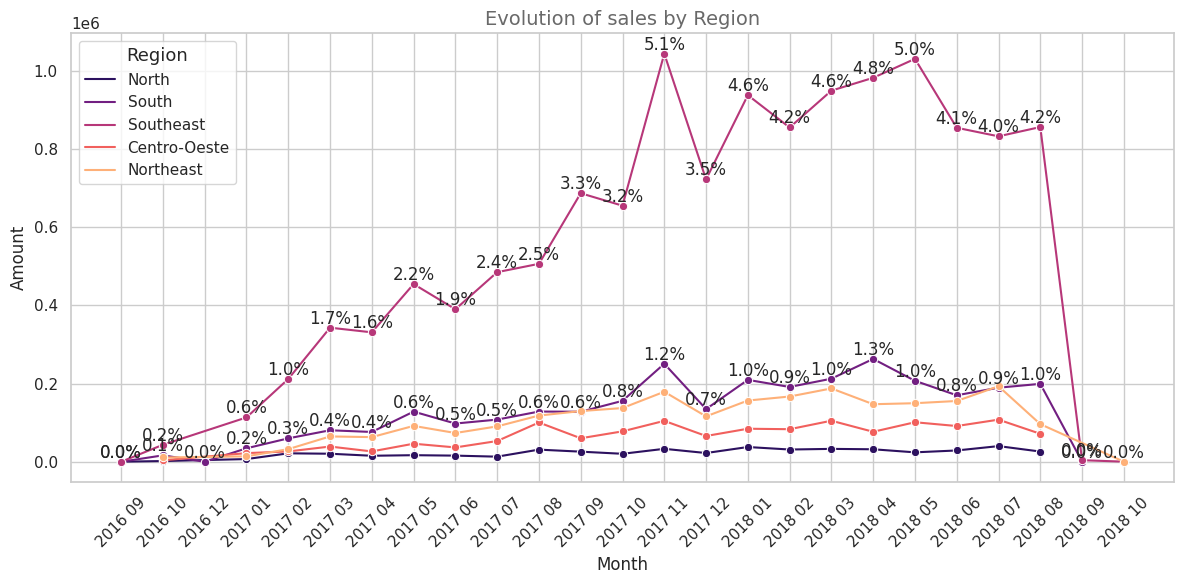

In [18]:
df_regions_group = df_train.groupby(by=['month_year', 'nome_regiao'], as_index=False)
df_regions_group = df_regions_group.agg({'customer_id': 'count', 'payment_value': 'sum'}).sort_values(by='month_year')
df_regions_group.columns = ['month', 'region', 'order_count', 'order_amount']
df_regions_group.reset_index(drop=True, inplace=True)

plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='order_amount', hue='region', data=df_regions_group, palette='magma', marker='o')

highlight_regions = ['South', 'Southeast']  
total_orders = df_regions_group['order_amount'].sum()

for region in df_regions_group['region'].unique():
    region_data = df_regions_group[df_regions_group['region'] == region]
    for i in range(len(region_data)):
        if region in highlight_regions:  
            percentage = (region_data['order_amount'].iloc[i] / total_orders) * 100
            plt.text(x=region_data['month'].iloc[i], 
                     y=region_data['order_amount'].iloc[i], 
                     s=f'{percentage:.1f}%', 
                     ha='center', va='bottom')

plt.title('Evolution of sales by Region', size=14, color='dimgrey')
plt.xlabel('Month', size=12)
plt.ylabel('Amount')
plt.xticks(rotation=45) 
plt.legend(title='Region', title_fontsize='13', fontsize='11')

plt.tight_layout() 
plt.show()


In [19]:
#import folium
#from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl

# Zipping locations
lats = list(df_train.query('year == 2018')['geolocation_lat'].dropna().values)[:30000]
longs = list(df_train.query('year == 2018')['geolocation_lng'].dropna().values)[:30000]
locations = list(zip(lats, longs))

# Creating a mapa using folium
map1 = folium.Map(location=[-15, -50], zoom_start=4.0)

# Plugin: FastMarkerCluster
FastMarkerCluster(data=locations).add_to(map1)

map1

The products with the highest distribution are located in the Southeast and South regions of Brazil, which are home to the largest population densities. For instance, the Southeast region, specifically São Paulo, has a population of approximately 12 million residents.

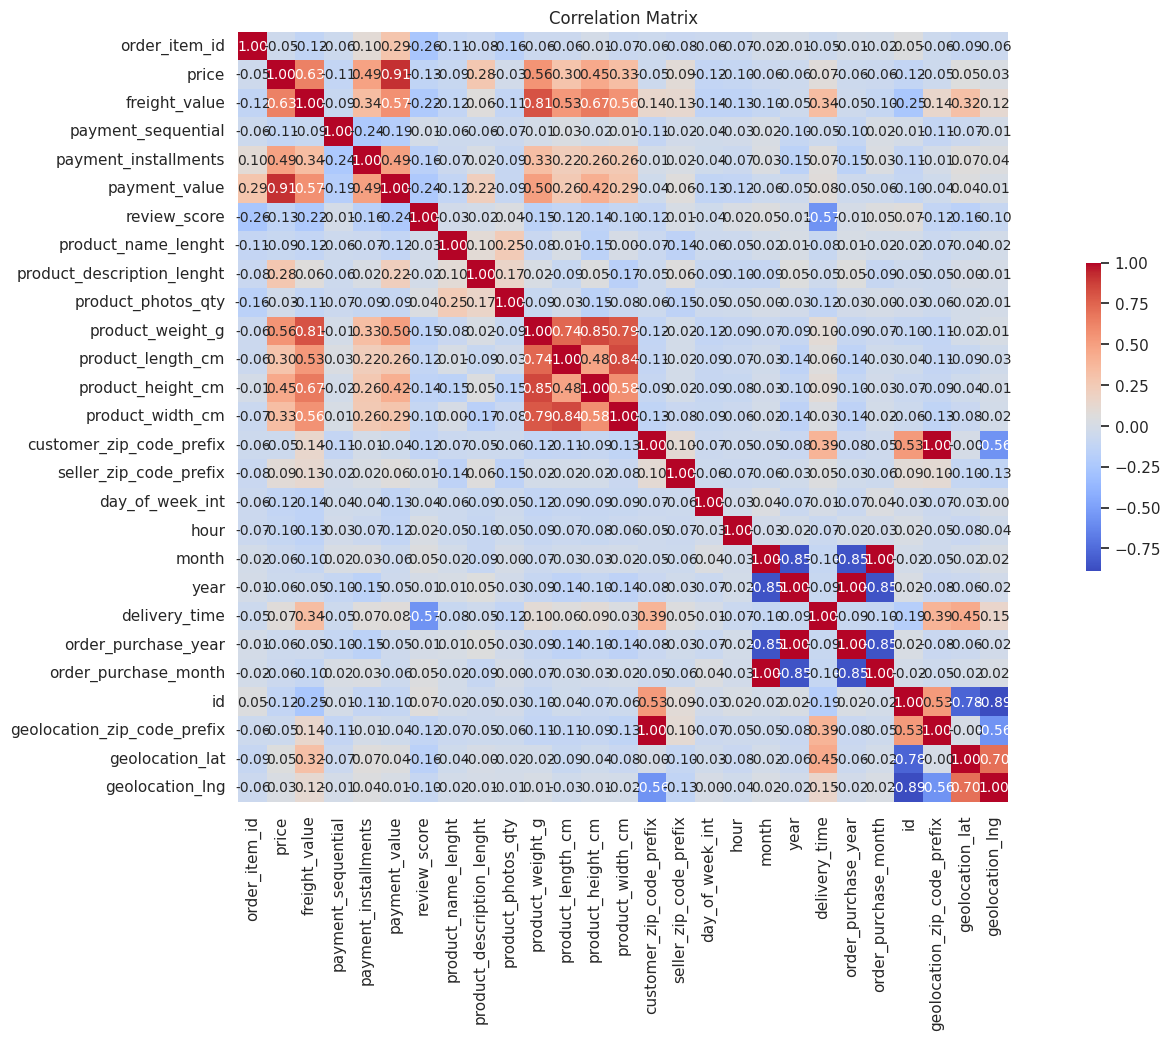

In [20]:
correlation_matrix = df_train.select_dtypes(include=[np.number]).corr()

correlation_matrix = correlation_matrix.corr()
plt.figure(figsize=(20, 10)) 
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, 
            cbar_kws={"shrink": .4}, annot_kws={"size": 10})  
plt.title('Correlation Matrix')
plt.show()
